 # Predicting E-Commerce Daily Revenue Using Gradient Boosting
 - [Description](#Description)
 - [Scraping Data](#Scraping-Data)
 - [Merging Data](#Merging-Data)
 - [EDA](#EDA)
 - [PCA and K-Means Clustering](#PCA-and-K-Means-Clustering)
 - [Feature Selection with LASSO](#Feature-Selection-with-LASSO)
 - [Boost Regression Forrest](#Boost-Regression-Forrest)
 - [Boost Regression Forrest Check](#Boost-Regression-Forrest-Check)
 - [Summary](#Summary)

# Description 

In 2020 the world shutdown: Everything that we were accustomed to doing in person became virutal. This is especially true for shopping. Granted, E-Commerce was already becoming more popular prior to the pandemic. The pandemic merely amplified E-Commerce activity as buying through E-Commerce shops quickly became a safe option to avoid the rapid spread of COVID. So naturally, when I cam across this anynonmous E-Commerce datset from [Kaggle](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store), I knew that I wanted to develop a project around it. After looking more into it, I saw that the data spanned from October 2019 to April 2020, which sparked a couple of ideas. 

First, I was curious about the relationship between COVID-19 and E-Commerce sales. Then the data science nerd in me was intriuged by the idea of merging a bunch of different datasets together. This ultimately led to a bigger project; Using daily COVID-19 confirmed cases, different E-Commerce stocks, the SP500, US presidential polling data, and other E-Commerce information how accurately could I predict daily revenue? Since most of this free data is reported daily, I decided to predict daily revenue. 

I was (am) excited as this is my first individual data science project. I truly feel passionate about this project and hope you enjoy looking at it! 

# Scraping Data

Scrapping the COVID-19 and US presidential polling data was straightforward as I had datalinks. Scrapping E-Commerce finance data was pretty straightforward as well. Since all the finance data was similar and from the same source, it made sense to go ahead and merge all the individual stock data immediately after the scrape. All of the data below is aggregated at the daily level, and provide a variety of interesting features for the future model. 


In [1]:
# Import the necessary packages to scrape the data for this project
import pandas as pd
import numpy as np
import opendatasets as od
import os

In [2]:
# A lot of the warnings in this notebook are due to XGBoost and LASSO are not perfectly compatible with the newest pandas
import warnings
warnings.filterwarnings("ignore")

**Scraping COVID-19 and Polling Data**

COVID-19 data was gathered to help answer my question about the relationship between this E-Commerce site's revenue and confirmed COVID-19 cases. Also, to see if COVID in general was important feature for predicting daily revenue. The COVID dataset contains the total confirmed COVID-19 cases for each day for a variety of countries. Some countries were divided into provinces like China, and the data spans from 01/22/2020 to 05/14/2022. 

The presidential polling was included just out for my own curiosity, and to determine if people's perception of the president could provide some insight on predicting this company's revenue. The Trump presidential dataset has variables on the Trump's daily approval rating and disapproval rating along with respective highs and lows for the rating estimates. The data is divided into subgroups of people, but for the purpose of this analysis, only the "All Polls" subgroup is needed. The data spans from 01/23/2017 to 01/20/2021, the duration of Trump's presidency. 

In [3]:
# Reading in data using data links

# Read the COVID-19 data from Github
Global_covid = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

# Read data on Trump approval ratings
Polls = pd.read_csv("https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv")

**Scraping Finance Data**

I chose these four E-Commerce ETF's as they each represetned a different aspect of the E-Commerce market. ProShares Online Retail (ONLN) ETF is representative of E-Commerce as a whole, and includes big E-Commerence names like Amazon. Emerging Markets Internet & Ecommerce (EMQQ) ETF emphasizes the fast-growing E-Commerce businesses. Amplify ETF Trust Amplify Online Retail (IBUY) ETF is one of the most popular E-Commerce ETFS. Global X E-commerce (EBIZ) ETF provides a wide spectrum of international E-Commerce businesses. 

Similarly, the SP500 was used a rough macroeconomic indicator of how the stock market/economy is doing. All of the stock data contains information on the open price, highest price, lowest price, closing price, adjusted closing price, and volume traded for each day. The finance data spans from 10/18/2018 to 03/07/2022 (when I collected the data). 

Since all of the stock datasets contain the same type of variables, it makes sense to go ahead and merge all of the finance data together now. So the below cell will scrape the finance data and also merge it.

In [4]:
# Scraping and merging finance data

# Since the SP500 has a weird ticker on Yahoo Finance (%5EGSPC), I decided to scrape the SP500 by itself and use it as the basis for the merger
SP500 = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=1488931200&period2=1646697600&interval=1d&events=history&includeAdjustedClose=true")
merged_finance = SP500.add_suffix('_SP500') #adding SP500 suffix
merged_finance.rename({'Date_SP500': 'day'}, axis=1, inplace=True) #renaming Date_SP500 colum to day for merging

# Creating a list of all the E-Commerce ETFs, then merging all of the ETFs to the merged finance dataframe
ETFs = ["EBIZ","IBUY","EMQQ","ONLN",]
for stock in ETFs:
    stocktemp = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/{0}?period1=1488931200&period2=1646697600&interval=1d&events=history&includeAdjustedClose=true".format(stock))
    stocktemp = stocktemp.add_suffix('_{0}'.format(stock)) #adding a suffix for each ETF
    stocktemp.rename({'Date_{0}'.format(stock): 'day'}, axis=1, inplace=True) #renaming Date column to day for merging
    merged_finance = pd.merge(merged_finance,stocktemp,on='day',how='inner')

**Downloading E-Commerce Data**

Downloading the E-Commerce data from Kaggle was pretty straight forward. Initially, aggregating the data was a little less intuiative. By creating a function, I was able to pretty easily define the columns that I wanted to construct in the new dataset, as the default aggregate function appeared to be relatively rigid. 

The Kaggle E-Commerce dataset is exceptionally thorough. Each record is time stamped by seconds, and each record describes one person's individual interaction with a good on their site. For example, one record contains what category the good was, what the brand was, the price of the good, the individual User id, unqiue session id, and the event type of the record (did the person purchase the good, remove the good from their cart, or simply view the good). The anynomous E-Commerce datasets only had two months of data on Kaggle: October 2019 and November 2019. So the cells below will scrape the Kaggle data, and later on I will scrape the addtional datasets from the Google Drive they were in. 

In [5]:
# Downloading the Kaggle E-Commerce data
od.download("https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store/download")

# Checking to make sure it downloaded
os.listdir()

Skipping, found downloaded files in ".\ecommerce-behavior-data-from-multi-category-store" (use force=True to force download)


['.ipynb_checkpoints',
 'datasets',
 'ecommerce-behavior-data-from-multi-category-store',
 'Predicting E-Commerce Daily Revenue Using Gradient Boosting.ipynb']

In [6]:
# Both Kaggle datasets are large (5 and 8 GB)
Oct2019 = pd.read_csv("C://Users//fishe//E-Commerce Econ 300 Project//ecommerce-behavior-data-from-multi-category-store//2019-Oct.csv")
Nov2019 = pd.read_csv("C://Users//fishe//E-Commerce Econ 300 Project//ecommerce-behavior-data-from-multi-category-store//2019-Nov.csv")

In [7]:
# Create function to aggregate data during group by for Kaggle data

# Wanted to create columns for event count(view, purchase, removed from cart) and for each main cateogry
def f(x):
    d = {}
    d['event_count'] = x['event_time'].count() #Includes the sum of all events for views, purchases, and removed from carts           
    d['view_count'] = x['event_type_view'].sum() 
    d['cart_count'] = x['event_type_cart'].sum()
    d['purchase_count'] = x['event_type_purchase'].sum()
    d['revenue'] = x[x['event_type_purchase']==1]['price'].sum() 
    d['appliances_count'] = x['category_appliances'].sum()
    d['construction_count'] = x['category_construction'].sum()
    d['sport_count'] = x['category_sport'].sum()
    d['apparel_count'] = x['category_apparel'].sum()
    d['computers_count'] = x['category_computers'].sum()
    d['furniture_count'] = x['category_furniture'].sum()
    d['kids_count'] = x['category_kids'].sum()
    d['auto_count'] = x['category_auto'].sum()
    d['accessories_count'] = x['category_accessories'].sum()
    return pd.Series(d, index=['event_count','view_count', 'cart_count', 'purchase_count','revenue','appliances_count',
                              'construction_count','sport_count','apparel_count','computers_count','furniture_count',
                              'kids_count','auto_count','accessories_count'])
    

**Reading E-Commerce Kaggle Data/ Aggregating Daily**

For deciding how I was going to aggregate the data, I evaluated what type of information I wanted to get out of the E-Commerce data. I knew I needed to aggregate to the daily level, as my other datasets are daily and not by seconds. Furthermore, I knew that I wanted to have some type of count for each event (how many people purchased an item on a given day, how many people would add an item to a cart, how many people would just view, etc.). I contemplated creating brand counts (for example, how many people bought an apple product on a given day), but I determined that there were too many brands, which would make the final dataset too wide. So, I decided just to use the product's category as a more broad replacement. 

In [8]:
# Combining and aggregating October and November to daily level data
months = ['Oct','Nov']
DailyNovOct = pd.DataFrame()
for x in months:
    data = pd.read_csv("C://Users//fishe//E-Commerce Econ 300 Project//ecommerce-behavior-data-from-multi-category-store//2019-{0}.csv".format(x))
    day = []                                 #Creating new day column
    eventime = data['event_time'].to_numpy()
    for t in eventime:                       #Have to split the time column up to split it differently
        temp1 = t.split("-")[1]
        temp2 = t.split("-")[2]
        temp2 = temp2.split(" ")[0]
        temp3 = temp1 + "/" + temp2          #New format will be mm/dd
        day.append(temp3)
    data["day"] = day
    category = []                            #Creating new category column
    codes = data['category_code'].to_numpy()
    for c in codes:                          #Have to split category_code to get the highest level category
        c = str(c)
        temp4 = c.split(".")[0]              #This retrieves the first category, which is the most broad
        category.append(temp4)
    data["category"] = category
    data=pd.get_dummies(data, columns=['category','event_type']) #Making dummy variables for the groupby function
    data_daily = data.groupby('day').apply(f)                    #Grouping by day and applying function f
    data_daily = pd.DataFrame(data_daily) 
    data_daily = data_daily.reset_index(level=0)                 #Reseting index of new daily dataframe
    DailyNovOct = pd.concat([DailyNovOct,data_daily])            #Appending daily data 

DailyNovOct.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\DailyECommerceDataNovOct.csv", index = None, header=True) 

**Scraping Google Drive E-Commerce Data/ Aggregating Daily**

Note that the below code **WILL NOT RUN ON YOUR COMPUTER**

The E-Commerce data from Kaggle and the additional E-Commerce data from Google Drive (December 2019 to April 2020), had to be unzipped and downloaded. So if you are running this notebook on your computer, please change the file path to where you want this data to be saved. Note that the Kaggle data is quite large, each month ranges from 8 to 12 GB of data. These files can eat up memory on your computer quickly. Keep this in mind when running the notebook and choosing where to house the original datasets. Thanks for reading the warning!

In [9]:
# Data from Google Drive
import gdown
url = "https://drive.google.com/drive/folders/1Nan8X33H8xrXS5XhCKZmSpClFTCJsSpE?usp=sharing" #URL for the Google Drive folder
gdown.download_folder(url, quiet=True, use_cookies=False) #Downloading the Google Drive folder

['C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\2019-Dec.csv.gz',
 'C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\2020-Apr.csv.gz',
 'C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\2020-Feb.csv.gz',
 'C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\2020-Jan.csv.gz',
 'C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\2020-Mar.csv.gz']

In [10]:
# Unzipping the Google Drive files and aggregating to daily level data
import gzip
import shutil
months = ['2019-Dec','2020-Jan','2020-Feb','2020-Mar','2020-Apr']
workingData = pd.DataFrame() 
for x in months:                            #Unzipping gz files (Google Drive files)
    with gzip.open('C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\{0}.csv.gz'.format(x), 'rb') as f_in:
        with open('C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\{0}.csv'.format(x), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out) 
    data = pd.read_csv('C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\{0}.csv.gz'.format(x)) #reading the newly downloaded data 
    day = []                                 #Creating a day column
    eventime = data['event_time'].to_numpy()
    for t in eventime:                       #Have to split the time column up to split it differently
        temp1 = t.split("-")[1]
        temp2 = t.split("-")[2]
        temp2 = temp2.split(" ")[0]
        temp3 = temp1 + "/" + temp2          #New format will be mm/dd
        day.append(temp3)
    data["day"] = day
    category = []                            #Creating new category column
    codes = data['category_code'].to_numpy()
    for c in codes:                          #Have to split category_code to get the highest level category
        c = str(c)
        temp4 = c.split(".")[0]              #This retrieves the first category, which is the most broad
        category.append(temp4)
    data["category"] = category
    data=pd.get_dummies(data, columns=['category','event_type']) #Making dummy variables for the groupby function
    data_daily = data.groupby('day').apply(f)                    #Grouping by day and applying function f
    data_daily = pd.DataFrame(data_daily)
    data_daily = data_daily.reset_index(level=0)                 #reseting index of new daily dataframe
    workingData = pd.concat([workingData,data_daily])                 #Appending daily data 

workingData.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\DailyECommerceData.csv", index = None, header=True)

The rest of the datasets that I clean are straightforward. I wanted to create a day column to merge each dataset together with, and I only wanted to keep the dates that the merged E-Commerce datset contained. I went ahead and narrowed each dataset rather than later since I wanted to cut down on computation time. Plus it made the tables easier to view as I progressed from each step. 

**COVID-19 Daily Data**

In [11]:
# Global COVID-19 Daily Data
Global_covid.loc["Total"] = Global_covid.sum() # Creating a column that holds all COVID cases on a given day
DatesG = Global_covid.iloc[:,4:104].columns.to_numpy() 
Covid_daily = Global_covid.groupby('Country/Region')[DatesG].apply(lambda x : x.astype(int).sum()) # Grouping by country

In [12]:
# Cleaning the Global covid data for merging
Covid_daily = Covid_daily.T 
Covid_daily = Covid_daily.reset_index()

# Creating a day column and fixing index
Covid_daily.rename({'index': 'day'}, axis=1, inplace=True)

# Renaming Total column as Global 
Covid_daily.rename(columns={ Covid_daily.columns[2]: "Global" }, inplace = True) 

# Only saving the countries we want to use, chose these countries since each one is in a different region, and had a lot of cases
Covid_daily_short = Covid_daily[['day','Brazil','China','Spain','US','Global']]
Covid_daily_short.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\GlobalCovid_daily.csv", index = None, header=True)

**Polls Daily Data**

In [13]:
# Only care about the all polls for this analysis
Polls_All = Polls[Polls['subgroup']=='All polls'][['modeldate','approve_estimate','approve_hi','approve_lo','disapprove_estimate','disapprove_hi','disapprove_lo']]

# Only want the dates that the Kaggle dataset has, doing this now to save computation time as well
b=Polls_All.loc[Polls_All['modeldate']=='10/1/2019'].index[0]
a=Polls_All.loc[Polls_All['modeldate']=='4/30/2020'].index[0]
Polls_date = Polls_All.loc[a:b,:]

# Cleaning the Polls data
Polls_date.rename({'modeldate': 'day'}, axis=1, inplace=True)
Polls_date=Polls_date.iloc[::-1]
Polls_date.reset_index(drop=True,inplace=True)

# Saving out to file path that we can extract from 
Polls_date.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\Polls_All_Daily1.csv", index = None, header=True)

**Finance Daily Data**

In [14]:
# Select only the days that are avaliable in the other datasets
merged_finance.set_index(['day'],inplace=True)
finance = merged_finance.loc['2019-10-01':'2020-04-30']
finance.reset_index(inplace=True)

# Saving finance dataset out for later
finance.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\finance.csv", index = None, header=True)

# Merging Data

Merging all of the datasets together was a lot easier since I cleaned them nicely earlier. There was some slight adjustments I had to make to the E-Commerce and Finance dataset. I also had to change the day column to format properly for the merge, but in general it was a clean and straightforward process. 

In [15]:
# Reading in data
Finance = pd.read_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\finance.csv",parse_dates=[0]) #2019-10-01
Polls = pd.read_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\Polls_All_Daily1.csv",parse_dates=[0]) #4/30/2020
Covid = pd.read_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\GlobalCovid_daily.csv",parse_dates=[0]) #4/30/20
EcomA = pd.read_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\DailyECommerceData.csv") #10-01
EcomB = pd.read_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\DailyECommerceDataNovOct.csv") #04/30

In [16]:
# Replacing - with / to correct mistake and format day properly
EcomB.day.replace({'-': '/'},inplace=True)

In [17]:
# Combining all the E-Commerce data together in datset called Ecom
Ecom = pd.concat([EcomB,EcomA]).reset_index(level=0,drop=True)

In [18]:
# Fixing Finance data to merge

# First adding weekend values by using Friday's stock information 
Finance = Finance.sort_values(by=['day'], ascending=[True])
Finance.set_index('day', inplace=True)
Finance = Finance.resample('D').ffill().reset_index()

In [19]:
# Fixing day format to merge with E-Commerce, only need Month and Days

# Finance data
Finance['day'] = Finance['day'].dt.strftime('%m/%d')

# Polls data
Polls['day'] = Polls['day'].dt.strftime('%m/%d')

# Covid data
Covid['day'] = Covid['day'].dt.strftime('%m/%d')

In [20]:
# Merging all the datasets into one master dataset

# Creating a set of all dataframes
dfs = [Ecom,Finance,Polls,Covid]

# Merging into masterdataframe df
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, on='day', how='outer'), dfs)

In [21]:
# Review Null values
dict(df.isnull().sum())

# For Covid data only, aligns with start and end date of dataset, 0 cases makes sense
df = df.fillna(0)

# Save new master dataframe as csv
df.to_csv("C:\\Users\\fishe\\E-Commerce Econ 300 Project\\datasets\\merged_maindataframe.csv", index = None, header=True)
df

,day,event_count,view_count,cart_count,purchase_count,revenue,appliances_count,construction_count,sport_count,apparel_count,...,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Brazil,China,Spain,US,Global
0,10/01,1244245.0,1208280.0,16658.0,19307.0,6275964.01,138852.0,23767.0,5302.0,38484.0,...,46.172290,36.785030,53.503940,57.627820,49.380070,0.0,0.0,0.0,0.0,0.0
1,10/02,1191328.0,1154591.0,17268.0,19469.0,6213628.53,137590.0,22882.0,5104.0,33391.0,...,45.844090,36.698860,53.842610,57.872020,49.813210,0.0,0.0,0.0,0.0,0.0
2,10/03,1127303.0,1088725.0,19323.0,19255.0,6233782.98,127924.0,20110.0,5128.0,28132.0,...,45.724640,36.691060,53.915110,57.909700,49.920520,0.0,0.0,0.0,0.0,0.0
3,10/04,1417190.0,1346320.0,43829.0,27041.0,8623684.47,185970.0,20062.0,5610.0,27526.0,...,46.089650,37.113530,53.715510,57.699650,49.731370,0.0,0.0,0.0,0.0,0.0
4,10/05,1330339.0,1271348.0,35497.0,23494.0,7341596.91,164871.0,18539.0,5945.0,29344.0,...,46.089650,37.113520,53.715510,57.699650,49.731360,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,04/26,2752012.0,2594705.0,117437.0,39870.0,9110739.61,619173.0,660363.0,151028.0,312908.0,...,47.251167,39.606291,52.447502,56.861902,48.033102,63100.0,86661.0,207634.0,975410.0,2974164.0
209,04/27,2564644.0,2404037.0,118904.0,41703.0,9614887.48,590453.0,634902.0,135510.0,295002.0,...,47.066718,39.450856,52.579022,56.931583,48.226462,67446.0,86692.0,209465.0,1000149.0,3045194.0
210,04/28,2648522.0,2489582.0,118271.0,40669.0,9343979.88,576920.0,655777.0,148802.0,324080.0,...,46.328493,38.869772,52.571193,56.717958,48.424429,73235.0,86754.0,210773.0,1024676.0,3120949.0
211,04/29,2703923.0,2545446.0,117806.0,40671.0,9440724.96,587898.0,682277.0,147146.0,318480.0,...,46.281516,38.844803,52.668005,56.718638,48.617373,79685.0,86783.0,212917.0,1051475.0,3198267.0


Now that I have a tidy and merged dataframe, I can move onto the exploratory data analysis!

# EDA

In [22]:
# Import graphing packages
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Created the following variables vizualization and analysis 

# COVID-19 Dummy
df['CovidDummy'] = (df.Global > 0).astype('int')

# Day Number 
df['day_number']=df.index
df.drop(['day'],axis=1,inplace=True)

# Checking my features to make sure they are all numbers
#dict(df.dtypes)

# Yes they are all numbers

Text(10.049999999999997, 0.5, 'Count')

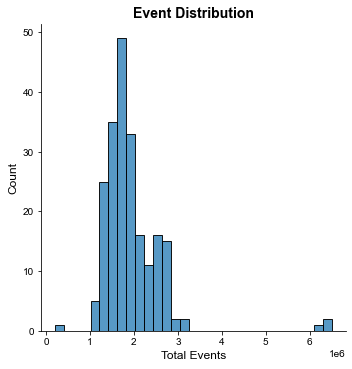

In [24]:
# Distribution of Event Counts
sns.displot(df, x="event_count",edgecolor="black")
sns.set_style('white')
plt.title('Event Distribution', fontsize=14, weight="bold")
plt.xlabel('Total Events', fontsize=12)
plt.ylabel('Count', fontsize=12)

For most of the days on this site, there are around 1 to 2 million "events" or interactions (purchases, views, removed from cart). Take note of the extreme outliers near 0 and above 6 million, as they will be important later.

Text(9.550000000000004, 0.5, 'Count')

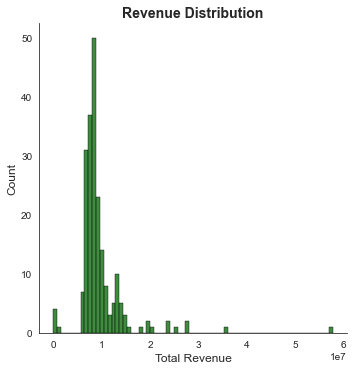

In [25]:
# Distribution of Revenue
sns.displot(df, x="revenue",color="darkgreen",edgecolor="black")
plt.title('Revenue Distribution', fontsize=14, weight="bold")
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Count', fontsize=12)

Daily revenue appears to be tightly centered around 10 million. However, the general shape of the distribution resembles the total event count. Also the outliers are still clearly visible as well.

Text(0.05000000000001137, 0.5, 'Purchase Count')

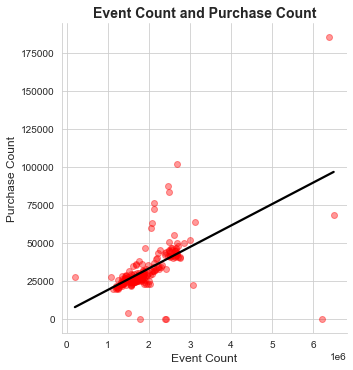

In [26]:
# Relationship between event count and purchase count
sns.set_style('whitegrid')
sns.lmplot(x = 'event_count', y = 'purchase_count', data = df, scatter_kws = {'alpha':0.4,'color':'red'},
           line_kws={'color':'black'},ci=None)
plt.title('Event Count and Purchase Count', fontsize=14, weight="bold")
plt.xlabel('Event Count', fontsize=12)
plt.ylabel('Purchase Count', fontsize=12)

There is some variance and dispersion in the graph. However, ignoring the major outliers, there appears to be a moderately strong positive correaltion between event count and pruchase count. This makes sense, as more people visit the site, more people are going to buy goods. 

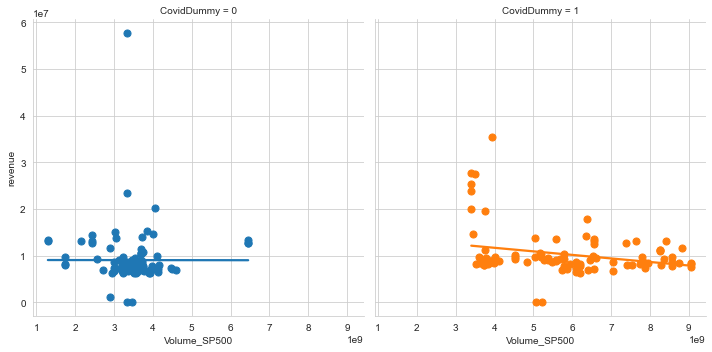

In [27]:
# Comparing SP500 volume against Revenue by COVID relevance 
sns.set_style('whitegrid')
sns.lmplot(x="Volume_SP500", y="revenue", data=df, ci=None, col='CovidDummy',col_wrap=2,scatter_kws={"s": 50, "alpha": 1},hue="CovidDummy")

Comparing the volume of SP500 traded daily to daily revenue, we see that revenue tends to stay clustered around the 10 million mark for both graphs. When COVID was prevelant, we can see the graph shifted substantially to the right as more people are trading the SP500. This is likely becase there was a global recession when COVID-19 struck, so people either panicked and sold their shares, or bought in at a relatively low price. Furthermore, it appears that the existence of COVID-19 doesn't really effect revenue: I found this pretty interesting.

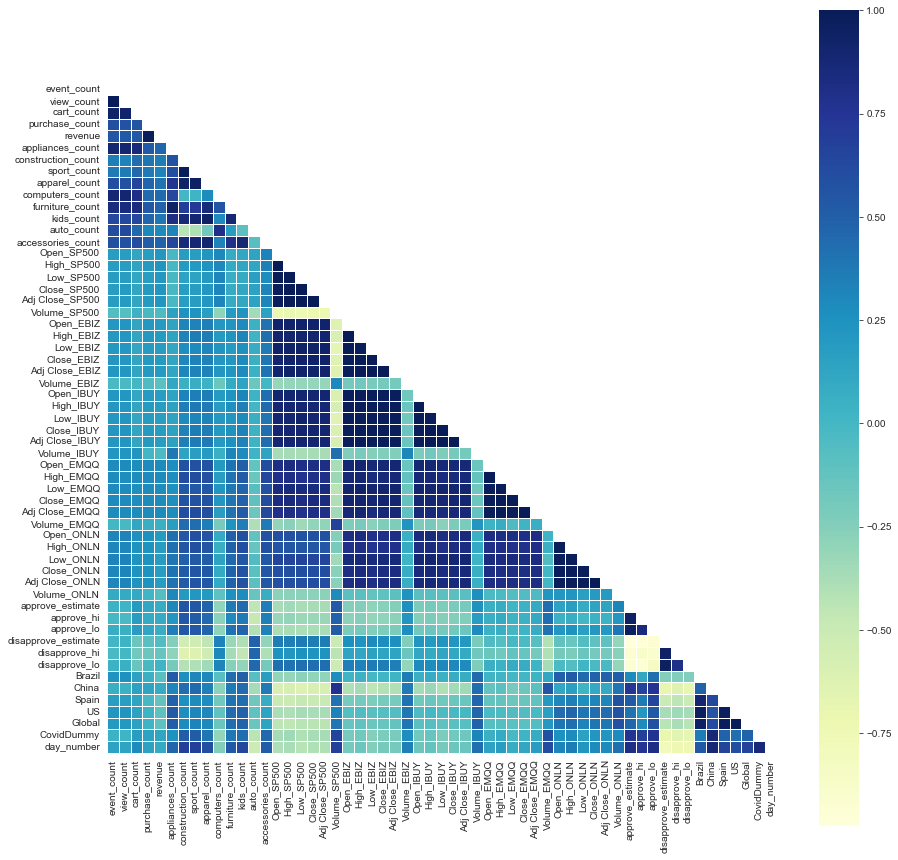

In [28]:
# Trinagle Heat map of each variable correlated with each other
corr = df.corr()                                       #Correlation of variables
mask = np.zeros_like(corr)                             #Forcing variables to have a correlation of 0
mask[np.triu_indices_from(mask)] = True                #Upper right triangle portion to have correlation of 0 (mask these cells)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="YlGnBu")

There is a lot of insight from this correlation matrix. Not a lot of features are heavily correlated with revenue outside of the E-Commerce site features (category counts and event counts). Most of the E-commerce ETF's are correlated with each other, which make nice 5x5 squares in the matrix. As expected, COVID-19 numbers in different countries are also correlated.

Also notice how the COVID-19 dummy nor the global confirmed cases are highly correlated with revenue. This goes against my intuition as the lockdown forced people to use online resources more. Perhaps this company is already big, so internet traffic didn't really change, or maybe the online transition lagged behind the intial scare of COVID in February to April. This dataset ends in April, so if more people visited the site in May as lockdowns increased, it would be impossible to tell.

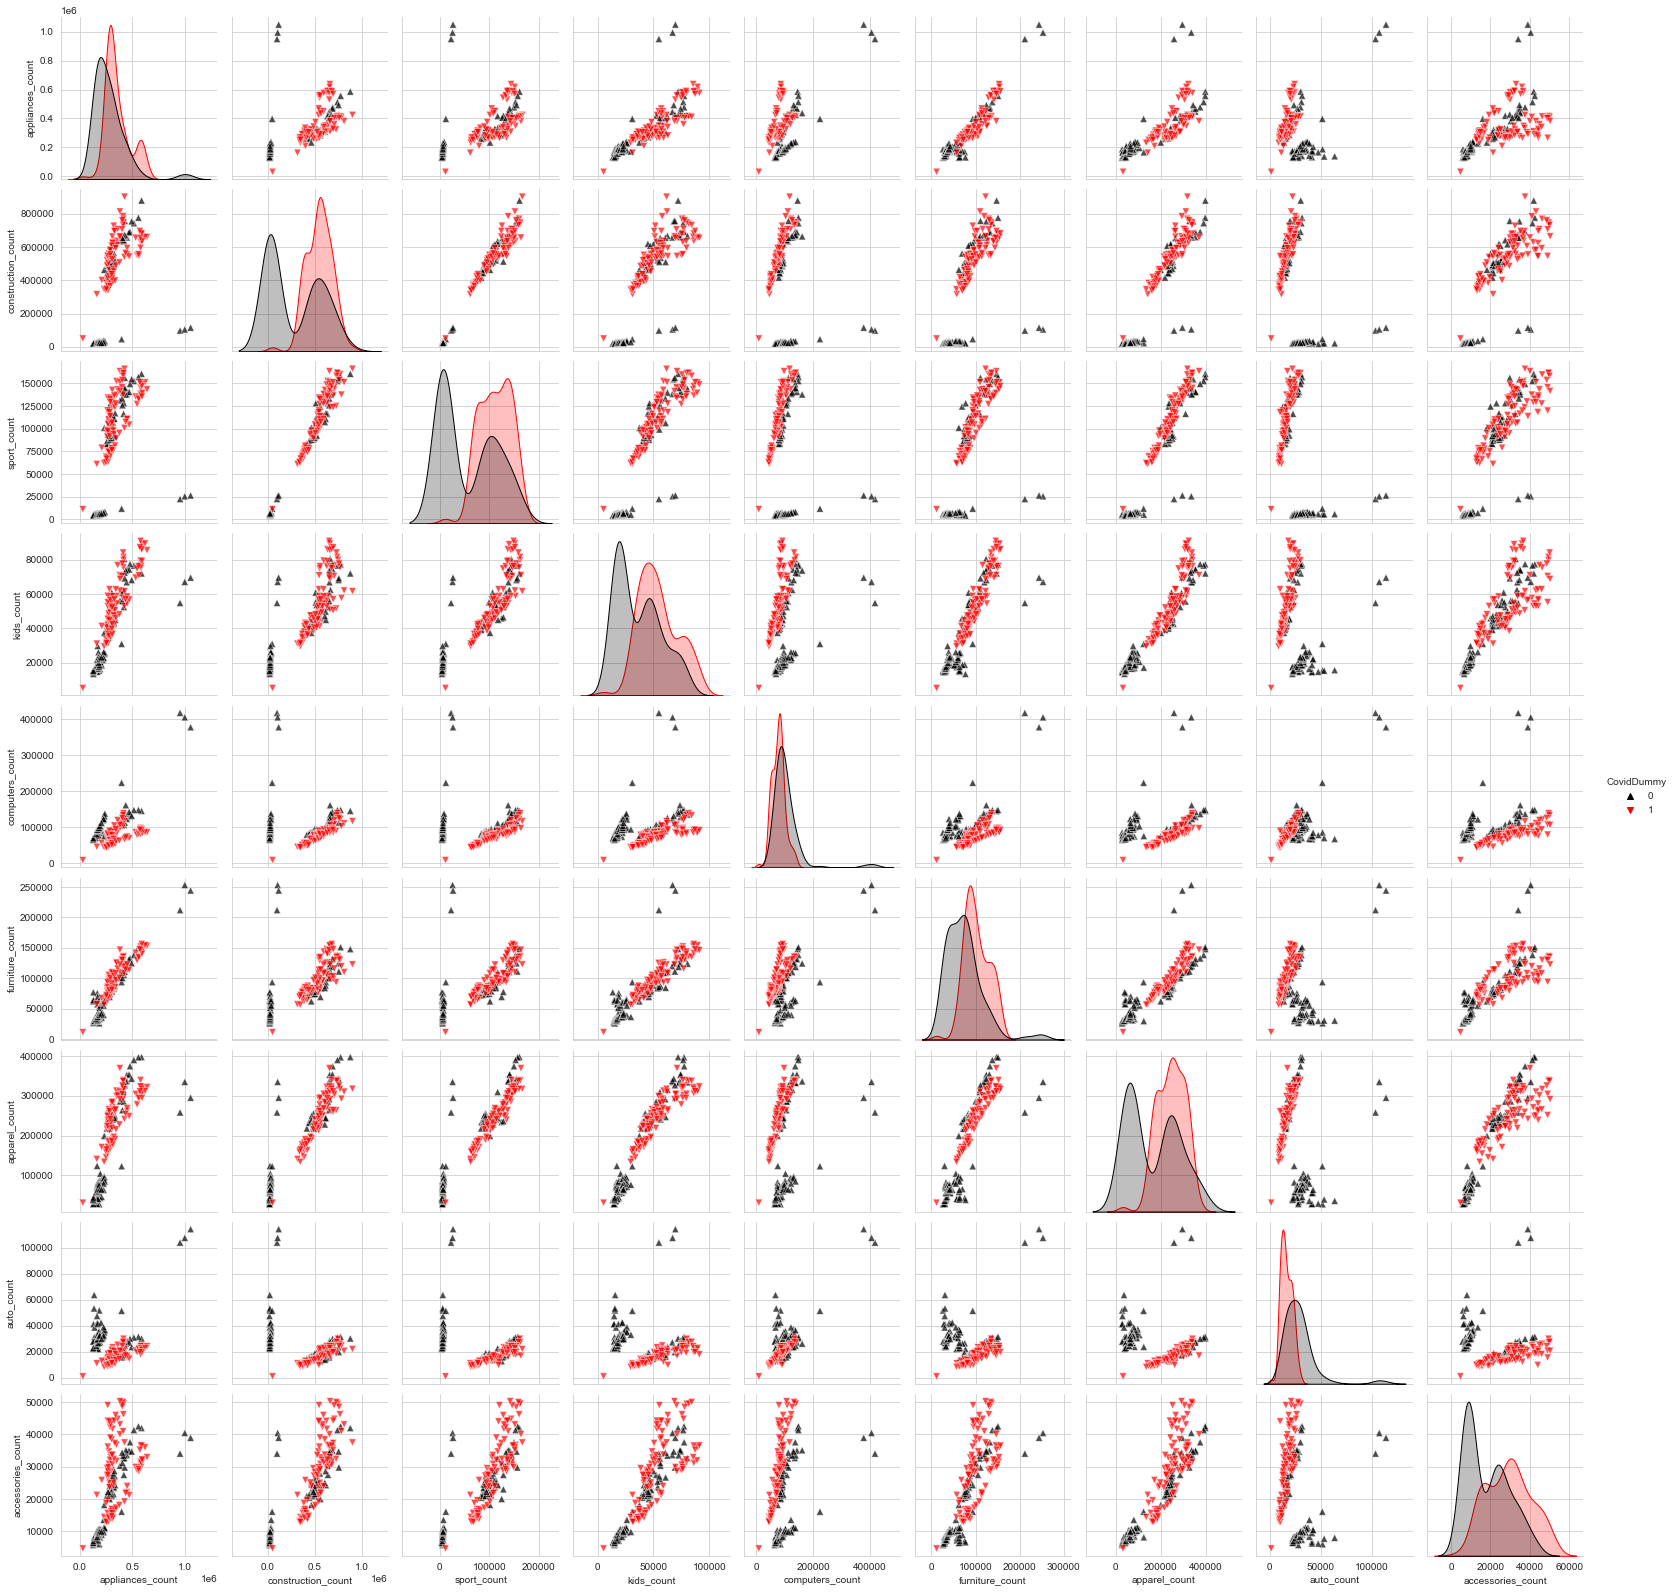

In [29]:
# Pairplot of categories, looking to see if any goods are substitutes or complimentary
sns.pairplot(df[['appliances_count','construction_count','sport_count','kids_count','computers_count','furniture_count','apparel_count','auto_count','accessories_count','CovidDummy']], hue ='CovidDummy',palette=["black", "red"],plot_kws=dict(s=50, alpha =0.7),markers=['^','v'])

Most of the categories appear to be copmlimentary goods, as they are each positvely correlated with each other. When there was 0 cases of COVID, there were not a lot of people buying construction, apparel, or sport goods. However, when COVID-19 did start to pop up, there was a significant increase in purchases for these types of goods. This could potentially be attributed to people picking up new hobbies, trying to workout and stay fit during lockdown, or starting DIY (do it yourself) projects. Conversely, people were buying less auto goods, as they were liking traveling less. 

**Big Takeaway from EDA**

COVID-19 doesn't effect revenue for this site as much as I anticipated, but consumer preferences on the site did change when COVID-19 became prevelant. 

# PCA and K-Means Clustering

The EDA above was insightful, but I wanted to learn a little bit more about the data. In particular, I wanted to see if the outliers would be clustered together and if the COVID-19 days would be clustered together. So, I decided to use K-Means clustering to group the data in clusters using unsupervised learning. Then to visualize the clusters, I used PCA to display the clusters on a 2-dimensional plane. This was the cleanest way I could come up with to evalaute how good the clusters actually are.   

In [30]:
# Importing the necessary packages for K-Means clustering and normalizing the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

I decided to list out all the variables, so I could go back and see what was actually included in the normalization. I also added the transformed (normalized) variables to the orginal dataset as it made the visualization easier. 

In [31]:
# First need to normalize the data
scaler = StandardScaler()

# Creating a list to refer back to of original column names, excluding covid dummy and day number
df_list = ['event_count','view_count','cart_count','purchase_count','revenue','appliances_count','construction_count','sport_count',
'apparel_count','computers_count','furniture_count','kids_count','auto_count', 'accessories_count', 'Open_SP500',
'High_SP500','Low_SP500','Close_SP500','Adj Close_SP500','Volume_SP500','Open_EBIZ','High_EBIZ','Low_EBIZ','Close_EBIZ',
'Adj Close_EBIZ','Volume_EBIZ','Open_IBUY','High_IBUY','Low_IBUY','Close_IBUY','Adj Close_IBUY','Volume_IBUY',
'Open_EMQQ','High_EMQQ','Low_EMQQ','Close_EMQQ','Adj Close_EMQQ','Volume_EMQQ','Open_ONLN','High_ONLN','Low_ONLN',
'Close_ONLN','Adj Close_ONLN','Volume_ONLN','approve_estimate','approve_hi','approve_lo','disapprove_estimate',
'disapprove_hi','disapprove_lo','Brazil','China','Spain','US','Global']

# Creating scalars (z-scores) for each value
scaler.fit_transform(df[df_list])

# New df columns that have been normalized 
df[['event_count_T','view_count_T','cart_count_T','purchase_count_T','revenue_T','appliances_count_T','construction_count_T','sport_count_T',
'apparel_count_T','computers_count_T','furniture_count_T','kids_count_T','auto_count_T','accessories_count_T','Open_SP500_T',
'High_SP500_T','Low_SP500_T','Close_SP500_T','Adj Close_SP500_T','Volume_SP500_T','Open_EBIZ_T','High_EBIZ_T','Low_EBIZ_T','Close_EBIZ_T',
'Adj Close_EBIZ_T','Volume_EBIZ_T','Open_IBUY_T','High_IBUY_T','Low_IBUY_T','Close_IBUY_T','Adj Close_IBUY_T','Volume_IBUY_T',
'Open_EMQQ_T','High_EMQQ_T','Low_EMQQ_T','Close_EMQQ_T','Adj Close_EMQQ_T','Volume_EMQQ_T','Open_ONLN_T','High_ONLN_T','Low_ONLN_T',
'Close_ONLN_T','Adj Close_ONLN_T','Volume_ONLN_T','approve_estimate_T','approve_hi_T','approve_lo_T','disapprove_estimate_T',
'disapprove_hi_T','disapprove_lo_T','Brazil_T','China_T','Spain_T','US_T','Global_T']] = scaler.fit_transform(df[df_list])

# Saving list of transformed names
df_list_T = ['event_count_T','view_count_T','cart_count_T','purchase_count_T','revenue_T','appliances_count_T','construction_count_T','sport_count_T',
'apparel_count_T','computers_count_T','furniture_count_T','kids_count_T','auto_count_T','accessories_count_T','Open_SP500_T',
'High_SP500_T','Low_SP500_T','Close_SP500_T','Adj Close_SP500_T','Volume_SP500_T','Open_EBIZ_T','High_EBIZ_T','Low_EBIZ_T','Close_EBIZ_T',
'Adj Close_EBIZ_T','Volume_EBIZ_T','Open_IBUY_T','High_IBUY_T','Low_IBUY_T','Close_IBUY_T','Adj Close_IBUY_T','Volume_IBUY_T',
'Open_EMQQ_T','High_EMQQ_T','Low_EMQQ_T','Close_EMQQ_T','Adj Close_EMQQ_T','Volume_EMQQ_T','Open_ONLN_T','High_ONLN_T','Low_ONLN_T',
'Close_ONLN_T','Adj Close_ONLN_T','Volume_ONLN_T','approve_estimate_T','approve_hi_T','approve_lo_T','disapprove_estimate_T',
'disapprove_hi_T','disapprove_lo_T','Brazil_T','China_T','Spain_T','US_T','Global_T']

In [32]:
# Checking new df dataset
df

,event_count,view_count,cart_count,purchase_count,revenue,appliances_count,construction_count,sport_count,apparel_count,computers_count,...,approve_hi_T,approve_lo_T,disapprove_estimate_T,disapprove_hi_T,disapprove_lo_T,Brazil_T,China_T,Spain_T,US_T,Global_T
0,1244245.0,1208280.0,16658.0,19307.0,6275964.01,138852.0,23767.0,5302.0,38484.0,69931.0,...,-0.871711,-1.019426,0.589849,0.403062,0.695121,-0.344790,-0.822079,-0.451136,-0.396715,-0.449644
1,1191328.0,1154591.0,17268.0,19469.0,6213628.53,137590.0,22882.0,5104.0,33391.0,66777.0,...,-1.147312,-1.081627,0.871250,0.609870,1.014116,-0.344790,-0.822079,-0.451136,-0.396715,-0.449644
2,1127303.0,1088725.0,19323.0,19255.0,6233782.98,127924.0,20110.0,5128.0,28132.0,64949.0,...,-1.247618,-1.087258,0.931490,0.641781,1.093147,-0.344790,-0.822079,-0.451136,-0.396715,-0.449644
3,1417190.0,1346320.0,43829.0,27041.0,8623684.47,185970.0,20062.0,5610.0,27526.0,85325.0,...,-0.941107,-0.782302,0.765642,0.463893,0.953843,-0.344790,-0.822079,-0.451136,-0.396715,-0.449644
4,1330339.0,1271348.0,35497.0,23494.0,7341596.91,164871.0,18539.0,5945.0,29344.0,78533.0,...,-0.941107,-0.782309,0.765642,0.463893,0.953836,-0.344790,-0.822079,-0.451136,-0.396715,-0.449644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2752012.0,2594705.0,117437.0,39870.0,9110739.61,619173.0,660363.0,151028.0,312908.0,86889.0,...,0.034259,1.017074,-0.287947,-0.245580,-0.296882,3.923742,1.423224,2.885604,3.508654,3.386226
209,2564644.0,2404037.0,118904.0,41703.0,9614887.48,590453.0,634902.0,135510.0,295002.0,85184.0,...,-0.120629,0.904875,-0.178667,-0.186568,-0.154478,4.217737,1.424027,2.915029,3.607705,3.477836
210,2648522.0,2489582.0,118271.0,40669.0,9343979.88,576920.0,655777.0,148802.0,324080.0,92227.0,...,-0.740542,0.485425,-0.185172,-0.367483,-0.008681,4.609346,1.425634,2.936049,3.705907,3.575539
211,2703923.0,2545446.0,117806.0,40671.0,9440724.96,587898.0,682277.0,147146.0,318480.0,93001.0,...,-0.779990,0.467401,-0.104731,-0.366907,0.133417,5.045670,1.426385,2.970503,3.813205,3.675259


In [33]:
# Defining X subset of data for K-Means Clustering with only normalized variables
X = df[df_list_T]

This is the  1  time through the cluserting loop. The distance is:  1455.9474439359076
This is the  2  time through the cluserting loop. The distance is:  1181.4826778851777
This is the  3  time through the cluserting loop. The distance is:  940.9418590101658
This is the  4  time through the cluserting loop. The distance is:  820.5958783925081
This is the  5  time through the cluserting loop. The distance is:  778.4731639649325
This is the  6  time through the cluserting loop. The distance is:  721.7432784245401
This is the  7  time through the cluserting loop. The distance is:  683.4538147099488
This is the  8  time through the cluserting loop. The distance is:  643.490278323167
This is the  9  time through the cluserting loop. The distance is:  619.1924227154552
This is the  10  time through the cluserting loop. The distance is:  581.8023905391949
This is the  11  time through the cluserting loop. The distance is:  553.2618081990527
This is the  12  time through the cluserting loop. 

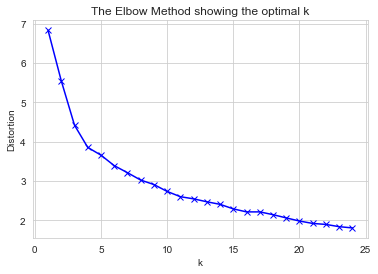

In [34]:
# Used Elbow plot to choose the optimal amount of clusters
from scipy.spatial.distance import cdist   # to calculate distance and evaluate cluster fit
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    print("This is the ", k," time through the cluserting loop. The distance is: ", sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)))
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    
# Plot the elbow
plt.figure(figsize = (6,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
# Fitting the KMeans model with 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

# Adding the cluster number to the df datset
df['kmeans_5'] = kmeans.labels_

It is somewhat difficult to determine the optimal amount of clusters based on an elbow graph. However, my first initial guess was around **5 clusters**. I did not feel comfortable only using the elbow method for this, and decided to cross check my guess with silhouette curve. 

In [36]:
# Import the necessary packages for Silhouettte curve
import matplotlib as mpl
from pylab import  rcParams
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.4521674022972716

In [37]:
# Calculating Silhouette scores for different number of k clusters
kmeans_per_k = [KMeans(n_clusters=k,random_state=50).fit(X) for k in range(1,15)]

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
silhouette_scores

[0.3243825044922282,
 0.38236587197733646,
 0.43270693887614636,
 0.4521674022972716,
 0.39872642021814586,
 0.36720565351615686,
 0.3554701405975057,
 0.3759776190749676,
 0.3757802507856016,
 0.35609700522888016,
 0.3235882694907836,
 0.3308151178646854,
 0.3304308281639506]

<function matplotlib.pyplot.show(close=None, block=None)>

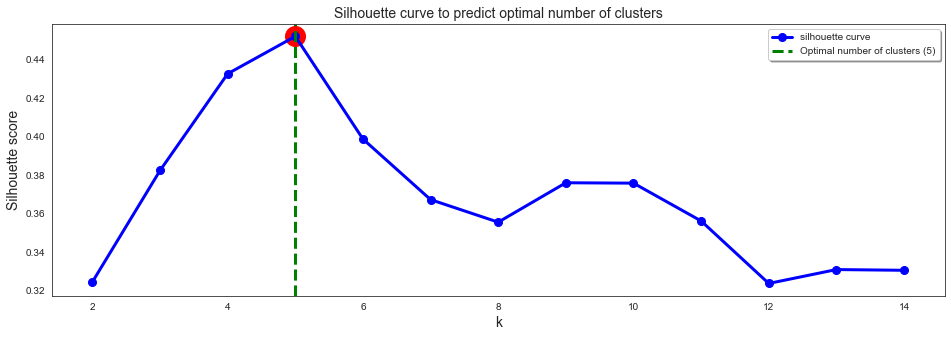

In [38]:
# Plot Silhouette curve graph
sns.set_style('white')
rcParams['figure.figsize'] = 16,5
plt.plot(range(2,15),silhouette_scores, "bo-", color='blue', 
         linewidth=3, markersize=8, label="silhouette curve")
plt.xlabel("k", fontsize=14, family='Arial',weight='normal')
plt.ylabel("Silhouette score", fontsize=14, family='Arial',weight='normal')
plt.title("Silhouette curve to predict optimal number of clusters", fontsize=14, family='Arial',weight='normal')


# Calculate optimal k value
k = np.argmax(silhouette_scores) + 2

# Draw verticle line to mark optimal number of clusters 
plt.axvline(x=k, linestyle='--', c = 'green', linewidth = 3, label = 'Optimal number of clusters ({})'.format(k))
plt.scatter(k,silhouette_scores[k-2],c='red',s=400)
plt.legend(shadow=True)
plt.show

The Silhoutte clearly depicts 5 as the optimal k value, so it looks like my initial guess was right! Now it is time to visualize the clusters.

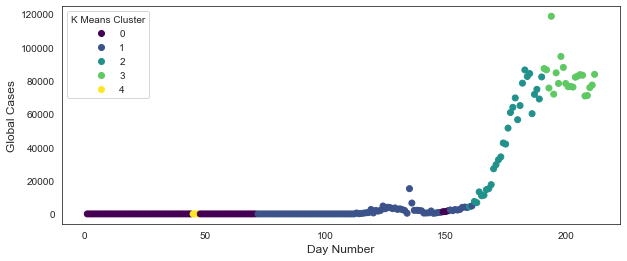

In [39]:
# Dispalying the additional confrimed COVID-19 cases each day and the 5 clusters
plt.figure(figsize = (10,4))
scatter = plt.scatter(x=df['day_number'],y=df.Global.diff(),c=df['kmeans_5'],cmap='viridis')
plt.ylabel("Global Cases", size=12)
plt.xlabel("Day Number", size=12)
plt.legend(handles=scatter.legend_elements()[0],
           labels=['0','1','2','3','4'],
           title="K Means Cluster")

For the above graph I chose additional COVID-19 cases rather than the cumalitive total cases per day. I knew that the total number of cases would make it difficult to differentiate between time and how COVID cases affected the clusters. Looking at the addtional cases, it appears that the clusters are picking up more on days that are close together rather than similar cases. If the clusters emphasized COVID cases, then the 60,000 to 80,000 range would all be yellow rather than divided between blue and yellow. Another good example would be the two dots in Cluster 2 that look as if they should be in the blue Cluster 1 if the clustering emphasized additional COVID cases. Let's look at revenue to see if we see a similar trend.

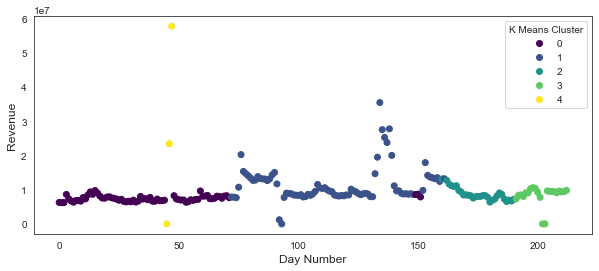

In [40]:
plt.figure(figsize = (10,4))
scatter = plt.scatter(x=df['day_number'],y=df['revenue'],c=df['kmeans_5'],cmap='viridis')
plt.ylabel("Revenue", size=12)
plt.xlabel("Day Number", size=12)
plt.legend(handles=scatter.legend_elements()[0],
           labels=['0','1','2','3','4'],
           title="K Means Cluster")

In [41]:
# Looking at clusters and the outliers we saw for revenue earlier
# The small revenue outliers
df[df["revenue"]<10000][["event_count","view_count","cart_count","purchase_count","revenue","kmeans_5"]]

,event_count,view_count,cart_count,purchase_count,revenue,kmeans_5
45,6220416.0,5737111.0,483305.0,0.0,0.00,4
93,1772949.0,1701594.0,71355.0,0.0,0.00,1
202,2391187.0,2276262.0,114903.0,22.0,6945.12,3


In [42]:
# The large revenue outliers
df[df["revenue"]>30000000][["event_count","view_count","cart_count","purchase_count","revenue","kmeans_5"]]

,event_count,view_count,cart_count,purchase_count,revenue,kmeans_5
47,6395377.0,5783241.0,426941.0,185195.0,57774481.92,4
134,2695049.0,2434404.0,158528.0,102117.0,35471760.02,1


At first glance the clusters look solid. It appears that the clustering heavily picked up on data points that are in similar time frames. For example, one of the lowest revenue points and highest revenue are all in Cluster 0 together. Also note how in Cluster 2 still encompasses the lows and peaks in the revenue. Perhaps the little bit of Cluster 3 in the Cluster 2 is concerning, but overall I would say the clusters look good! However, it is hard to tell if the clusters are good since I am condesning a 55 dimensional graph into a 2-dimensional plane. So let's use PCA to get a more accurate representation of how good these clusters look.

In [43]:
# Developing a 2-dimensional PCA table for clustering visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)           
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['kmeans_5']]], axis = 1)

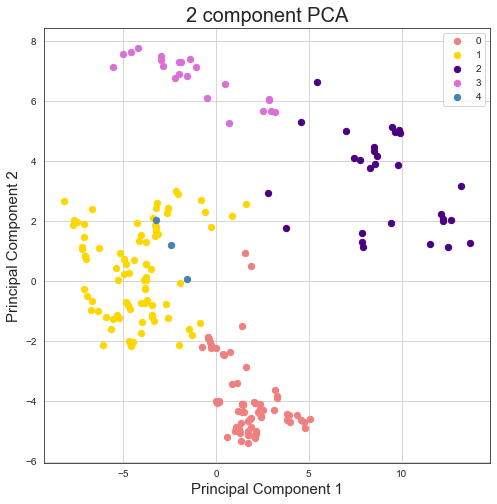

In [44]:
# PCA graph based on K-Means Cluster
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3,4]
colors = ['lightcoral','gold','indigo','orchid','steelblue']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['kmeans_5'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

For the most part, the 5 clusters are well defined and seperated. Cluster 0 is unique with only three data points, and some of the edges of the clusters might be questionable (especially for Clusters 1 and 2). Note that we did see a lot of the clusters followed the linear progression of time, which does explain some of the clusters like Cluster 0. In general, I would argue that these clusters are sufficient.

**Big Takeaway from Clustering**

These clusters are heavily influenced by time. Interestingly, neither the total number of COVID cases nor the daily amount of revenue majorily determined these clusters. From this we can infer that days that are closer together in time are often more alike than days with similar revenue ranges or confirmed COVID-19 cases. 

# Feature Selection with LASSO

Now that I am more familiar with the data and the relationship between COVID-19 and revenue, it is time to start the first step of our modeling. First I need to narrow down the feature list by using LASSO, then I will use a Boost regression forrest to predict revenue with the most important features.

In [45]:
# Importing packages needed for LASSO and the feature selection
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [60]:
# Prepping for Lasso

# Only want original df features, do not want normalzied versions
df.drop(df_list_T, axis=1, inplace=True)

# Define features
X1 = df.drop(['revenue','kmeans_5'],axis=1)

# Define target variable
y=df.revenue

# split and train
X_train, X_test, y_train, y_test = train_test_split(X1,y, test_size=0.25, random_state=50)

In [61]:
# Fit Lasso model to evaluate most important variables and their magnitude with the optimal alpha
lassocv = LassoCV(alphas = None, cv=10, max_iter = 100000, normalize = True, random_state=50)
lassocv.fit(X_train, y_train)
lassocv.predict(X_test)
lassocv.score(X_test, y_test) 

mse = mean_squared_error(y_test, lassocv.predict(X_test))
print("RMSE: %.2f" % (mse**(1/2.0)))
print("The optimal lasso alpha is:",lassocv.alpha_)

# Some of the coefficients are now reduced to exactly zero.
lasso_ft=pd.Series(lassocv.coef_, index=X_train.columns)

# We now have ar recuded feature list with the most important features
features = lasso_ft[lasso_ft!=0].reset_index()['index']
print(features)

RMSE: 512138.20
The optimal lasso alpha is: 555.4517321419527
0             view_count
1         purchase_count
2     construction_count
3          apparel_count
4        computers_count
5             kids_count
6             auto_count
7            Close_SP500
8        Adj Close_SP500
9              High_EBIZ
10           Volume_EBIZ
11           Volume_IBUY
12        Adj Close_EMQQ
13           Volume_ONLN
14            approve_lo
15         disapprove_hi
16         disapprove_lo
17                Brazil
18                 China
19                    US
20            CovidDummy
Name: index, dtype: object


**Feature Selection and LASSO Conclusion**

The LASSO model had a relatively high root mean square error around 512,000. Surely I can do better than that. Using the LASSO reduced feature list from above, I am now going to develop a boost forrest model to predict revenue, which should lead to a more accurate model as well.

# Boost Regression Forrest

In [62]:
# Redefining features and target for the model 

# X variables with most important features
X = df[features]

# Redefine target variable for clearity
y = df.revenue

In [65]:
# Develop a Boost model wit default parameters 

# Import necessary packages for XGBoost model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split model again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

# Use default parameters
params = {'objective':'reg:squarederror'}
       
# Instantiate the regressor 
model = XGBRegressor(**params)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Create y predictions
y_pred = model.predict(X_test)

# Check RMSE/ Evaluate fit 
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 367136.45


**Default Model**

The default forrest regression is substantially better than the LASSO model (367,136 compared to LASSO's 511,989.77). However, I have a gut feeling that after some tampering this model can produce an even lower RMSE than LASSO.

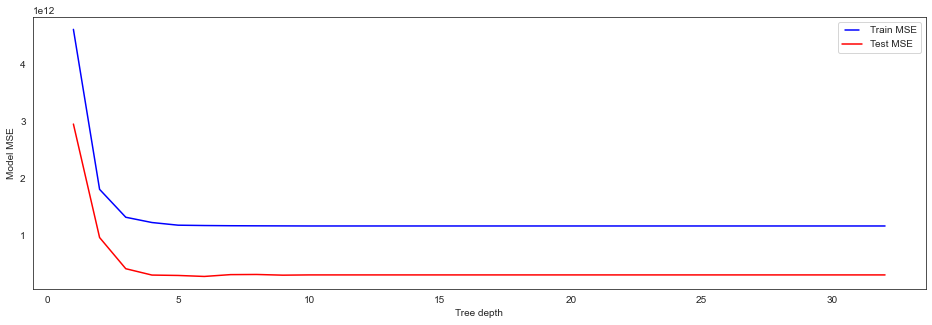

In [66]:
# Finding the maximum tree depth for the parameter
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths: 
   xgb = XGBRegressor(n_estimators = 10, random_state = 50, max_depth=int(max_depth)) #testing out different depths
   xgb.fit(X_train, y_train)
   train_pred = xgb.predict(X_train) #on training data
   train_results.append(mse(train_pred, y_train)) #appending the results
   
   test_pred = xgb.predict(X_test) #on testing data
   test_results.append(mse(test_pred, y_test)) #appending the results

# Plotting the results to determine what the optimal max tree depth is
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train MSE")
line2, = plt.plot(max_depths, test_results, 'r', label="Test MSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Model MSE')
plt.xlabel('Tree depth')
plt.show()

From the previous graph the optimal maximum tree depth appears to be **4**. Using a random search, I will be able to find the other optimal parameters for the boost forrest model.

In [70]:
# Importing pakcage for Random Search
from sklearn.model_selection import RandomizedSearchCV

# Setting parameters
params = { 'colsample_bytree': np.arange(0.4, 1.1, 0.1),
           'learning_rate': np.arange(0.01, .11, 0.01),
           'n_estimators': [100, 500, 1000], 
           'alpha': np.arange(100, 210, 10)}

# Set seed for comparative purposes
xgbr = XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=50)
# Fit model
clf.fit(X, y)

# Print best parameters for model
print("Best parameters:", clf.best_params_)

Best parameters: {'n_estimators': 1000, 'learning_rate': 0.09999999999999999, 'colsample_bytree': 0.9999999999999999, 'alpha': 110}


Now its time to fit a new model with the best parameters from above. 

In [71]:
# Import R^2 to evaluate model
from sklearn.metrics import r2_score

# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

from xgboost import XGBRegressor

# Use the same parameters that were optimized in the cell above
params = {'objective':'reg:squarederror','colsample_bytree': 1,'learning_rate': 0.01,
                'max_depth': 4, 'alpha':110, 'n_estimators':1000}
       
# Instantiate the regressor 
model = XGBRegressor(**params)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Create y predictions
y_pred = model.predict(X_test)

# Check RMSE/ Evaluate fit 
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 321795.55


**Optimized Boost Model is the Best**

An optimized model has an even lower root mean square error compared to the default parameters (321,795.55 to the default's    367,136.45). Now let's graph the predicitons of the test data versus the actuals to get an idea of how good the model is.

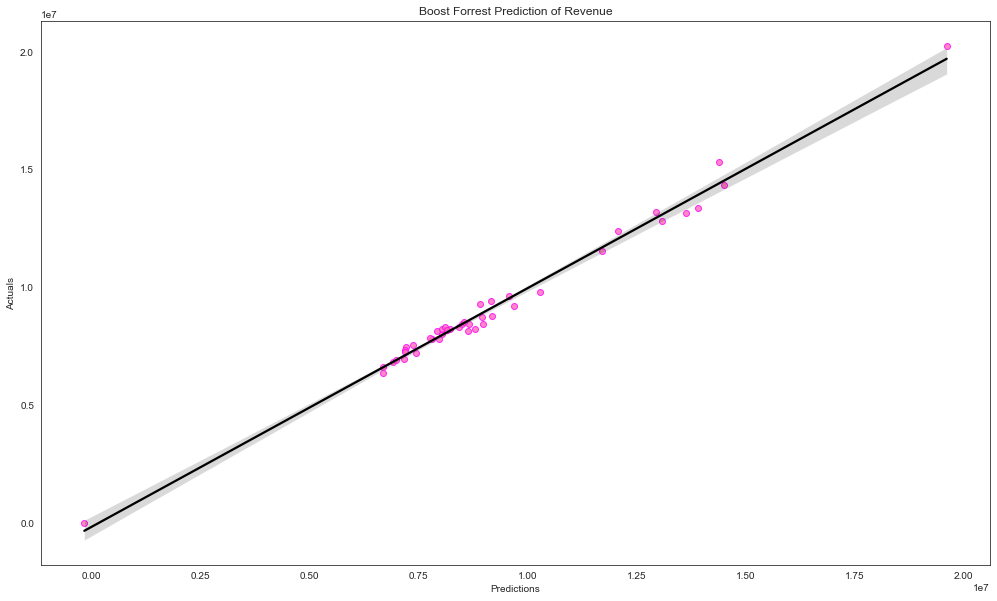

In [72]:
# Plot the predictions vs actual to demonstrate the accuracy of the model
plt.figure(figsize=(17,10))
sns.regplot(y_pred,y_test,scatter_kws={'color':'hotpink','edgecolor':'magenta','linewidth':1,'alpha':.8},line_kws={'color':'black','alpha':1})
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title("Boost Forrest Prediction of Revenue")
plt.show()

The optimized boost model appears to have been extremely accurate at predicitng revenue. Most of the daily revenue are tightly dispersed across the line of best fit. Let's see what features were the most important for this model.

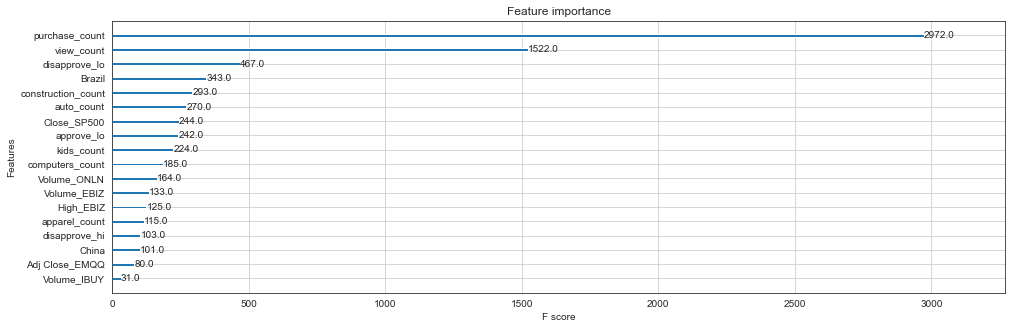

In [73]:
# Plot feature importance
import xgboost as xgb
xgb.plot_importance(model)
plt.show()

Purchase count and view count are by far the most important features. Out of curiosity, I am going to develop a second boost model using the optimized parameters. However, this time the new model will not include purchase or view count. This should indicate how strong our model is at predicting without those two prominant features. 

# Boost Regression Forrest Check

RMSE: 1756626.73


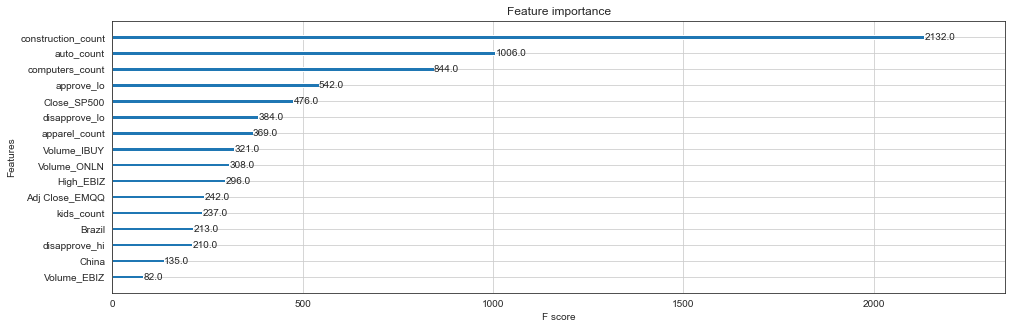

In [75]:
# Drop purchase and view counts
Xnew = X.drop(['purchase_count','view_count'],axis=1)

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size = 0.2, random_state = 50)

from xgboost import XGBRegressor

# Use the same parameters that were optimized 
params = {'objective':'reg:squarederror','colsample_bytree': 1,'learning_rate': 0.01,
                'max_depth': 4, 'alpha':110, 'n_estimators':1000}
       
# Instantiate the regressor 
model = XGBRegressor(**params)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Create y predictions
y_pred = model.predict(X_test)

# Check RMSE/ Evaluate fit 
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

# Plot feature importance
xgb.plot_importance(model)
plt.show()

Without visualizing the accuracy, by dropping the two most important features in the best model, the RMSE has signifcantly increased. Remember, the best model had a RMSE at 321,795.55 and this model has a value at 1,756,626.73. 

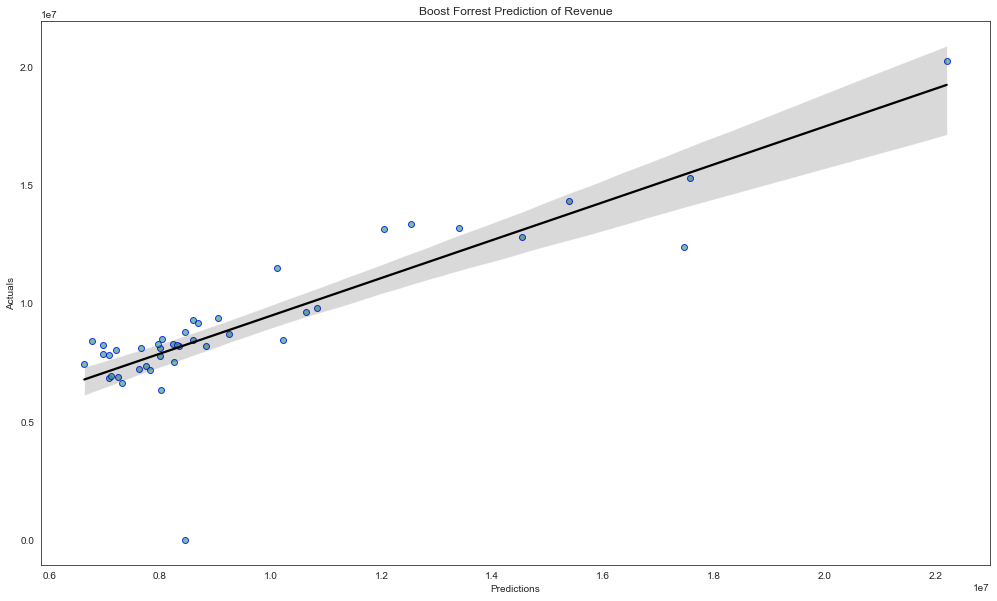

In [76]:
# Plot the predictions vs actual to demonstrate the accuracy of the new model
plt.figure(figsize=(17,10))
sns.regplot(y_pred,y_test,scatter_kws={'color':'#4CB391','edgecolor':'blue','linewidth':1,'alpha':.8},line_kws={'color':'black','alpha':1})
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title("Boost Forrest Prediction of Revenue")
plt.show()

With the new model, we can see that the data has become more dispered and the errors have increased. However, I would still argue that this model predicts daily revenue fairly well, especially since it is missing the two most prominent features. Thus, with full confidence I can say that I have developed a sound model to predict daily revenue for this E-Commerce site! 

# Summary

I was originally curious about the relationship between this anynomous E-Commerce site's revenue and COVID-19. From the EDA, we say that confirmed COVID-19 cases and revenue were not highly correlated with each other. However, from EDA we also saw that consumer preferences did change when COVID-19 started to emerge. From the K-Means and PCA analysis, we saw that COVID nor revenue heavily effected the clusters in our dataset. Despite the time variable not being included in the K-means model, the clusters appeared to be heavily influenced by time. From this we can infer that days that are closer together in time are often more alike than days with similar revenue ranges or confirmed COVID-19 cases. All of this alludes to the idea that COVID-19 confirmed daily cases and daily revenue do not signifcantly influence each other, nor are they as important to identifying similarities between days as I first anticipated. 

The main goal of this project was to predict daily revenue for the E-Commerce site. I used LASSO regression for feature reduction, and for the first model. The LASSO model produced a root mean squared error (RMSE) of 511,989.77. Next, I used the XGBoost model to predict daily revenue. The default Gradient Boosting model resulted in a RMSE of 367,136.45. The optimized gradient boosting model produced a RMSE of 367,136.45, which is by far the best model. Graphing this optimized gradient boosting model, we can see that the predictions are extremely accurate. Furthermore, as a robustness check, I excluded view and purchase count from the same model. This new model has a RMSE substantially higher than the previous models at 1,756,626.73. When graphing the new model, we can see that the data is more disperesed and the errors have increased, but in general the model is still fairly accurate. Therfore with high confidence I can say that I constructed a sound model that can predict daily revenue for this E-Commerce site! Thank you for reading my project and hope you enjoyed the journey as much as I have.
